In [1]:
#Import dependencies - plotting
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
#Import dependencies - dataframe, computation, storage, et.al.
import numpy as np
import pandas as pd
import re
import csv
import math
import scipy
from scipy import stats
import pingouin as pg
from statsmodels.stats.weightstats import ttest_ind

In [3]:
#Import dependencies - date values and formats
import datetime as dt
from datetime import datetime
from datetime import date
from datetime import timedelta
import calendar

In [4]:
# Import dependencies - SQLalchemy
import sqlalchemy
from sqlalchemy import create_engine

In [5]:
# Import dependencies - browser exposure, API formatting
import json
import flask
from flask import Flask, jsonify

In [6]:
# Create an engine for the hawii.sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

# Step 1 - Climate Analysis and Exploration 

### SQLalchemy -- Return LTM Precipitation Data

Records (rows) = 365


Text(0, 0.5, 'Inches')

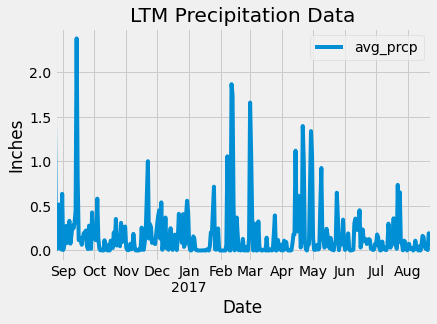

In [7]:
query = '''
    SELECT
        date,
        AVG(prcp) AS avg_prcp
    FROM
        measurement
    WHERE
        date > (SELECT date(MAX(date),'-1 year') FROM measurement)
    GROUP BY
        date
    ORDER BY
        date ASC
'''

# Save SQL query into dataframe
prcp_ltm_df = pd.read_sql(query, conn)

# Convert date column to date-format
prcp_ltm_df['date'] = pd.to_datetime(prcp_ltm_df['date'])

# Sort dataframe on date
prcp_ltm_df = prcp_ltm_df.sort_values('date')

# Set the index to date
prcp_ltm_df = prcp_ltm_df.set_index('date')

#Verification
print(f'Records (rows) = {len(prcp_ltm_df)}')

# Pandas Plotting to plot LTM precipitation
prcp_ltm_df.plot(title='LTM Precipitation Data', rot=0)
plt.xlabel('Date')
plt.ylabel('Inches')

### SQLalchemy - Station Data - Total Number of Weather Stations

In [8]:
query = '''
    SELECT
        COUNT(*) AS station_count
    FROM
        station
'''

ttl_station_count =  pd.read_sql(query, conn)
ttl_station_count = ttl_station_count.values[0]
print(f"Total weather stations = {ttl_station_count}")

Total weather stations = [9]


### SQLalchemy - Station Data - Number of Active Weather Stations for LTM Period

In [9]:
query = '''
    SELECT 
        COUNT (DISTINCT(s.name))
    FROM
        measurement m
        LEFT JOIN station s
        ON m.station = s.station
    WHERE
        m.prcp IS NOT NULL
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)
'''

active_stations_ltm =  pd.read_sql(query, conn)
active_stations_ltm = active_stations_ltm.values[0]
print(f"Total weather stations active during LTM period = {active_stations_ltm}")

Total weather stations active during LTM period = [7]


### SQLalchemy - Station Data - Weather Stations Ordered by Precipitation Observations for Period 2010-2017

In [10]:
query = '''
    SELECT 
        s.station,
        s.name,
        COUNT(*) AS precip_obs
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        m.prcp IS NOT NULL
    GROUP BY
        m.station,
        s.name
    ORDER BY
        precip_obs DESC
'''
stations_by_activity_level_full_period_df =  pd.read_sql(query, conn)
stations_by_activity_level_full_period_df

,station,name,precip_obs
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00513117,"KANEOHE 838.1, HI US",2696
2,USC00519397,"WAIKIKI 717.2, HI US",2685
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2484
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,USC00517948,"PEARL CITY, HI US",683
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",342


### SQLalchemy - Station Data - Weather Stations Ordered by Precipitation Observations for LTM Period

In [11]:
query = '''
    SELECT 
        s.station,
        s.name,
        COUNT(*) AS precip_obs
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        m.prcp IS NOT NULL
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)
    GROUP BY
        m.station,
        s.name
    ORDER BY
        precip_obs DESC
'''
stations_by_activity_level_df =  pd.read_sql(query, conn)
stations_by_activity_level_df

,station,name,precip_obs
0,USC00519397,"WAIKIKI 717.2, HI US",358
1,USC00519281,"WAIHEE 837.5, HI US",351
2,USC00513117,"KANEOHE 838.1, HI US",342
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",327
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",313
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",264
6,USC00517948,"PEARL CITY, HI US",60


### SQLalchemy - Station Data - Weather Stations Ordered by Temperature Observations for Period 2010-2017

In [12]:
query = '''
    SELECT 
        s.station,
        s.name,
        COUNT(*) AS temp_obs
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        m.tobs IS NOT NULL
    GROUP BY
        m.station,
        s.name
    ORDER BY
        temp_obs DESC
'''
stations_tobs_activity_level_full_period_df =  pd.read_sql(query, conn)
stations_tobs_activity_level_full_period_df

,station,name,temp_obs
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


### SQLalchemy - Station Data - Weather Stations Ordered by Temperature Observations for LTM Period

In [13]:
query = '''
    SELECT 
        s.station,
        s.name,
        COUNT(*) AS temp_obs
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        m.tobs IS NOT NULL
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)
    GROUP BY
        m.station,
        s.name
    ORDER BY
        temp_obs DESC
'''
stations_tobs_activity_level_df =  pd.read_sql(query, conn)
stations_tobs_activity_level_df

,station,name,temp_obs
0,USC00519397,"WAIKIKI 717.2, HI US",360
1,USC00519281,"WAIHEE 837.5, HI US",351
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",348
3,USC00513117,"KANEOHE 838.1, HI US",342
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",336
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",304
6,USC00517948,"PEARL CITY, HI US",182


### SQLalchemy - Station Data - Most Active Weather Station for 2010-2017 Period
(by both Precipitation Observations and Temperature Observations, as it happens) 

In [14]:
stations_by_activity_level_full_period_df

,station,name,precip_obs
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00513117,"KANEOHE 838.1, HI US",2696
2,USC00519397,"WAIKIKI 717.2, HI US",2685
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2484
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,USC00517948,"PEARL CITY, HI US",683
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",342


In [15]:
most_active_station_full_period = stations_by_activity_level_full_period_df.values[0,1]

most_active_station_full_period_id = stations_by_activity_level_full_period_df.values[0,0]

# for convenience
name = most_active_station_full_period
name1 = name.title()
name2 = name1.replace(" ", "")
name3 = re.search(r"[a-zA-Z]*", name2).group()
name4 = re.sub(r"(?<=\w)([A-Z])", r" \1", name3)
most_active_station_full_period = name4

print(f"The {most_active_station_full_period} Weather Station was the most active for the period 2010-2017 with \
{stations_by_activity_level_full_period_df.values[0,2]} precipitation observations \nand \
{stations_tobs_activity_level_full_period_df.values[0,2]} temperature observations.")

The Waihee Weather Station was the most active for the period 2010-2017 with 2772 precipitation observations 
and 2772 temperature observations.


### SQLalchemy - Station Data - Most Active Weather Station for LTM Period
(by both Precipitation Observations and Temperature Observations, as it happens) 

In [16]:
most_active_station_ltm = stations_by_activity_level_df.values[0,1]

most_active_station_ltm_id = stations_by_activity_level_df.values[0,0]

# for convenience
name = most_active_station_ltm
name1 = name.title()
name2 = name1.replace(" ", "")
name3 = re.search(r"[a-zA-Z]*", name2).group()
name4 = re.sub(r"(?<=\w)([A-Z])", r" \1", name3)
most_active_station_ltm = name4

print(f"The {most_active_station_ltm} Weather Station was the most active for the LTM period with \
{stations_by_activity_level_df.values[0,2]} precipitation observations \nand {stations_tobs_activity_level_df.values[0,2]} \
temperature observations.")

The Waikiki Weather Station was the most active for the LTM period with 358 precipitation observations 
and 360 temperature observations.


### SQLalchemy - Station Data - Temperature Histogram of Most Active Station for Period 2010-2017

Records (rows) = 2772


Text(0, 0.5, 'Frequency')

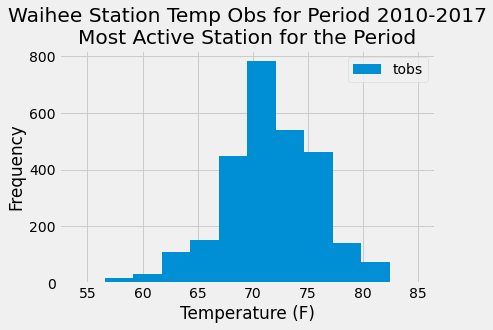

In [17]:
query = f'''
    SELECT 
        m.tobs
    FROM
        measurement m
    WHERE
        m.station = '{most_active_station_full_period_id}'        
    ORDER BY
        m.date ASC
'''
no1_active_tobs_station_df2 =  pd.read_sql(query, conn)
print(f"Records (rows) = {len(no1_active_tobs_station_df2)}")
no1_active_tobs_station_df2.head()

no1_active_tobs_station_df2.plot.hist(bins=12, title=f'{most_active_station_full_period} Station Temp Obs for Period \
2010-2017\nMost Active Station for the Period')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')

In [18]:
no1_active_tobs_station_df2.head()

,tobs
0,70.0
1,62.0
2,74.0
3,75.0
4,74.0


### SQLalchemy - Station Data - Temperature Histogram of Most Active Weather Station for the LTM Period

Records (rows) = 360


Text(0, 0.5, 'Frequency')

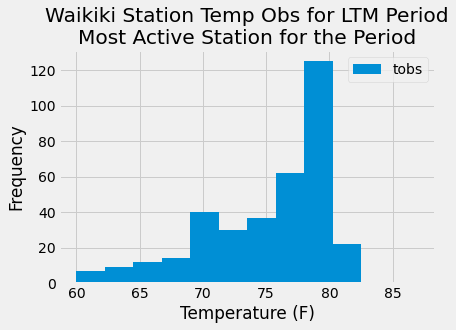

In [19]:
query = f'''
    SELECT 
        m.tobs
    FROM
        measurement m
    WHERE
        m.station = '{most_active_station_ltm_id}'
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)
    ORDER BY
        m.date ASC
'''
no1_active_tobs_station_df =  pd.read_sql(query, conn)
print(f"Records (rows) = {len(no1_active_tobs_station_df)}")
no1_active_tobs_station_df.head()

no1_active_tobs_station_df.plot.hist(bins=12, title=f'{most_active_station_ltm} Station Temp Obs for LTM \
Period\nMost Active Station for the Period')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')

### SQLalchemy - Station Data - Avg, High, and Low of Most Active Weather Station for the Period 2010-2017

In [20]:
query = f'''
    SELECT 
        MIN(m.tobs) AS low_temp,
        MAX(m.tobs) AS high_temp,
        AVG(m.tobs) AS avg_temp
    FROM
        measurement m
    WHERE
        m.station = '{most_active_station_full_period_id}'            
'''
temp_obs_full_period_df = pd.read_sql(query, conn)
print(f"\nLow, Mean, and High Temps for Period 2010-2017 for {most_active_station_full_period} Weather Station")
temp_obs_full_period_df


Low, Mean, and High Temps for Period 2010-2017 for Waihee Weather Station


,low_temp,high_temp,avg_temp
0,54.0,85.0,71.663781


### SQLalchemy - Station Data - Avg, High, and Low of Most Active Weather Station for the LTM Period

In [21]:
query = f'''
    SELECT 
        MIN(m.tobs) AS low_temp,
        MAX(m.tobs) AS high_temp,
        AVG(m.tobs) AS avg_temp
    FROM
        measurement m
    WHERE
        m.station = '{most_active_station_ltm_id}'
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)    
'''
temp_obs_ltm_period_df = pd.read_sql(query, conn)
print(f"\nLow, Mean, and High Temps for LTM Period for {most_active_station_ltm} Weather Station")
temp_obs_ltm_period_df


Low, Mean, and High Temps for LTM Period for Waikiki Weather Station


,low_temp,high_temp,avg_temp
0,60.0,87.0,75.194444


### SQLalchemy - Station Data - Function for low, high, and average temperature for an user-selected period across all weather stations

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TMIN, and TAVG for a list of dates.
    
    Args:
        # start_date_str (string): A date string in the format %Y-%m-%d
        # end_date_str (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    query = f'''
    SELECT 
        MIN(m.tobs) AS low_temp,
        MAX(m.tobs) AS high_temp,
        AVG(m.tobs) AS avg_temp
    FROM
        measurement m
    WHERE
        m.date BETWEEN '{start_date}'  AND '{end_date}'
    '''
    temp_obs_df = pd.read_sql(query, conn)
    
    temp_stats = tuple(temp_obs_df.values[0])
    
    return temp_stats

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 74.0, 69.57142857142857)


#### NOT ENOUGH TIME TO GENERATE FULLY METHODOLOGICALLY SOUND WEIGHTED AVERAGE

I believe the AVG formula used in the function 2 cells above is methodologically unsound for our purposes in that it implicitly weights by frequency of observations.  So, as an example, let's say you have a set of observations for 3 dates across 7 stations.  And let's say day 1 has 3 stations report temperature observations, day 2 has 4 stations report, and day 3 has all 7 stations report.  So, that means that day 3 accounts for 50% of the 3-day average temperature value you are calculating.  And let's say that days 1 and 2 are close to full-set average temperatures and day 3 is abnormally cold (beyond 1 STD vs. true full set).  That means our calculation (sample) would be distorting accurate representation of average temperature for a true full set.  It does so by not weighting each day slice equally.  BUT TO FIX the problem, let's say we take an average across all stations before we then subsequently take an average of those averages.  A subsequent issue might arise.  Let's say the stations that fail to report on days 1 and 2 are at higher elevations (typically colder average temperatures), but our solution averages the available reporting stations for a particular day.  That would mean for both days 1 and 2, on average we would be over-weighting warmer measurements (because the typically colder stations' values are not available).  So to REALLY FIX the issue, the methodologically sound thing to is to determine the typical variance between the stations (e.g., relative to station A, station B is typically 5 degrees F cooler, station C is 10 degrees F cooler,...)  That would compensation for systematic temperature differences (presumably due to altitude, which we have in the dataset BTW).  So, you would have a formula that would compensate for those differences in the missing station tobs values as you take a daily average across all stations before taking an average of those daily averages for the entire period.

### SQLalchemy - Station Data - Methodologically weighted average temperature for user-selected period - start and end date
(more accurate, but still not fully methodologically sound)

In [23]:
# This function called `calc_temps_better_method` will accept start date and end date in the format '%Y-%m-%d' 
# and return the weighted average temperature for that range of dates
def calc_temps_better_method(start_date, end_date):
    """TMIN, TMAX, and TWAVG for a list of dates.
    
    Args:
        # start_date (string): A date string in the format %Y-%m-%d
        # end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TMAX, and TWAVG
    """

    query = f'''
            SELECT
                MIN(dmin) as min_t,
                MAX(dmax) as max_t,
                AVG(davg) as wavg_t
            FROM 
                (SELECT
                    MIN(m.tobs) AS dmin,
                    MAX(m.tobs) AS dmax,
                    AVG(m.tobs) AS davg
                FROM
                    measurement m
                WHERE
                    m.date BETWEEN '{start_date}' AND '{end_date}'
                GROUP BY
                    m.date
                ORDER BY
                    m.date
                ) AS P;
            '''
    temps_better_method_df = pd.read_sql(query, conn)
    
    temps_better_method = tuple(temps_better_method_df.values[0])
    
    return temps_better_method

# function usage example
print(calc_temps_better_method('2012-02-28', '2012-03-05'))

(62.0, 74.0, 69.48837868480726)


### SQLalchemy - Station Data - Methodologically weighted average temperature for user-selected period - start date only 
(more accurate, but still not fully methodologically sound)

In [24]:
# This function called `calc_2_temps_better_method` will accept a start date without end date in the format '%Y-%m-%d' 
# and return the weighted average temperature for a range including that date and all dates forward
def calc_2_temps_better_method(start_date):
    """TMIN, TMAX, and TWAVG for a list of dates.
    
    Args:
        # start_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TMAX, and TWAVG
    """

    query = f'''
            SELECT
                MIN(dmin) as min_t,
                MAX(dmax) as max_t,
                AVG(davg) as wavg_t
            FROM 
                (SELECT
                    MIN(m.tobs) AS dmin,
                    MAX(m.tobs) AS dmax,
                    AVG(m.tobs) AS davg
                FROM
                    measurement m
                WHERE
                    m.date >= '{start_date}'
                GROUP BY
                    m.date
                ORDER BY
                    m.date
                ) AS P;
            '''
    temps_2_better_method_df = pd.read_sql(query, conn)
    
    temps_2_better_method = tuple(temps_2_better_method_df.values[0])
    
    return temps_2_better_method

# function usage example
print(calc_2_temps_better_method('2012-02-28'))

(53.0, 87.0, 73.53610061622796)


#### FURTHER OBSERVATION
If I read the instructions right, this isn't a forensic analysis.  Rather, we're supposed to be planning a vacation (in the future).  We want to know record high, record low, and average temperature for the historical temperature data set.  Basically, for TMAX, if we're taking a hypothetical 2 day trip (let's say April 4, 2021 thru April 5, 2021), we want to know the record high temperature every April 4 and every April 5 from 2010 thru 2017.  And similarly so, for TMIN, it's lows across every April 4 and every April 5 from 2010 thru 2017.  And for TAVG, it's similar but with the issues I cited above about weighting.

### SQLalchemy - Station Data - Vacation Planner Using Any Dates in the Future 
(more accurate, but still not fully methodologically sound)

In [25]:
# This function called `vaca_calc_temp` will accept start date and end date in the format '%Y-%m-%d' 
# for vacations for any dates in the future and return the low, high, and weighted average temperature for 
# that range of dates.

global vaca_start_date
global vaca_end_date

def vaca_calc_temp(vaca_start_date, vaca_end_date):
    
    vacation_dates_x = []
    vacation_dates = [vaca_start_date,vaca_end_date]
    for date_x in vacation_dates:
        vals_x = date_x.split("-")
        vacation_date_x = '2021' + "-" + vals_x[1] + "-" + vals_x[2]
        vacation_dates_x.append(vacation_date_x)
    
    """TMIN, TMAX, and TWAVG for a list of dates.
    
    Args:
        # start_date_str (string): A date string in the format %Y-%m-%d
        # end_date_str (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TMAX, and TWAVG
    """

    query = f'''

    SELECT 
        MIN(dmin) as min_t,
        MAX(dmax) as max_t,
        AVG(davg) as wavg_t
    FROM 
        (SELECT
            MIN(m.tobs) AS dmin,
            MAX(m.tobs) AS dmax,
            AVG(m.tobs) AS davg
            
         FROM
            measurement m
         WHERE
            m.date BETWEEN -- 2010
                (SELECT date('{vacation_dates_x[0]}','-11 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-11 year') FROM measurement)

            OR m.date BETWEEN -- 2011
                (SELECT date('{vacation_dates_x[0]}','-10 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-10 year') FROM measurement)

            OR m.date BETWEEN -- 2012
                (SELECT date('{vacation_dates_x[0]}','-9 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-9 year') FROM measurement)

            OR m.date BETWEEN -- 2013
                (SELECT date('{vacation_dates_x[0]}','-8 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-8 year') FROM measurement)

            OR m.date BETWEEN -- 2014
                (SELECT date('{vacation_dates_x[0]}','-7 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-7 year') FROM measurement)

            OR m.date BETWEEN -- 2015
                (SELECT date('{vacation_dates_x[0]}','-6 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-6 year') FROM measurement)

            OR m.date BETWEEN -- 2016
                (SELECT date('{vacation_dates_x[0]}','-5 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-5 year') FROM measurement)

            OR m.date BETWEEN -- 2017
                (SELECT date('{vacation_dates_x[0]}','-4 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-4 year') FROM measurement)

         GROUP BY
            m.date
         ORDER BY
            m.date
        ) AS P;
        '''
    
    global vaca_temp_df
    
    vaca_temp_df = pd.read_sql(query, conn)
    
    vaca_temp = tuple(vaca_temp_df.values[0])
    
    return vaca_temp

# function usage example
print(vaca_calc_temp('2027-04-04', '2027-04-18'))

(58.0, 82.0, 72.08811507936507)


In [26]:
vaca_temp_df

,min_t,max_t,wavg_t
0,58.0,82.0,72.088115


# Step 2 - Climate App
(Refer to file app.py (same folder) for this work, which is derivative of the work performed in Step 1)

# Step 3 - Data Analyses

## SQLalchemy - Data Analyses - (1) Daily Rainfall and Temperature

### SQLalchemy - Daily Rainfall and Temperature - 1. Rainfall per weather station using most recent prior year's matching dates

In [27]:
today_date = date.today()
vals_y = str(today_date).split("-")
adjust_date = '2021' + "-" + vals_y[1] + "-" + vals_y[2]
   
query = f'''
        SELECT
            m.station,
            s.name,
            m.date,
            m.prcp
        FROM
            measurement m
            JOIN station s
            ON m.station = s.station
        WHERE
            m.date = (SELECT date ('{adjust_date}' , '-5 year') FROM measurement)
            OR m.date = (SELECT date ('{adjust_date}' , '-4 year') FROM measurement)
        ORDER BY
            m.date DESC
        '''

# Save SQL query into dataframe
x_df1 = pd.read_sql(query, conn)

# Ensure we get only most recent date - as query output sorted in descending, we take only highest listed unique date
x_df1 = x_df1.loc[x_df1['date'] == x_df1['date'].unique()[0]]
    
# Preview dataframe
x_df1 

,station,name,date,prcp
0,USC00519397,"WAIKIKI 717.2, HI US",2016-12-14,0.03
1,USC00513117,"KANEOHE 838.1, HI US",2016-12-14,0.05
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2016-12-14,0.12
3,USC00517948,"PEARL CITY, HI US",2016-12-14,NaN
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2016-12-14,0.05
5,USC00519281,"WAIHEE 837.5, HI US",2016-12-14,0.92
6,USC00516128,"MANOA LYON ARBO 785.2, HI US",2016-12-14,0.33


### SQLalchemy - Daily Rainfall and Temperature - 2a. Daily Rainfall Normals (low, high, avg)

In [28]:
# Query all dates in hawaii.sqlite database
query = f''' SELECT m.date FROM measurement m '''
x_df2 = pd.read_sql(query, conn)
x_dates = x_df2["date"]

# Extract a list of unique month_day values
month_day_list = []
for x_date in x_dates:
    vals_x = str(x_date).split("-")
    month_day_x = vals_x[1] + "-" + vals_x[2]
    month_day_list.append(month_day_x)
    month_day_df = pd.DataFrame(month_day_list)
    month_day_df = month_day_df.sort_values(by=[0])
    month_day_list_unique = month_day_df[0].unique()
    
# Set dictionary to generate empty lists to capture each date corresponding to each of the 366 unique month_day values
month_day_dict = {month_day:[] for month_day in month_day_list}

In [29]:
# Extract all year values in data set

start_date_str = str(x_dates.min())
end_date_str = str(x_dates.max())

# Generate a list of years extracted from the data set
def create_year_list(r1, r2): 
    return [item for item in range(r1, r2+1)] 
      
# "Drivers"
r1 = int(start_date_str.split("-")[0])
r2 = int(end_date_str.split("-")[0])

year_list = create_year_list(r1, r2)

year_list = map(str, year_list)  
year_list = list(year_list)
year_list

['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

In [30]:
# Ensure dictionary of lists is reset
for key in month_day_dict:
    month_day_dict[key] = []

# Traverse the year list and a column of month-day values to create a list of historical annual dates corresponding 
# to each month-day value

def add_element(month_day_dict, key, value):       # Define a function for appending the dictionary
    if key not in month_day_dict:
        month_day_dict[key] = []
    month_day_dict[key].append(value)    

for key in month_day_dict:

    for year in year_list:
        
        ndate = []                                # Reset by clearing the date creator container
            
        ndate = f"{year}-{key}"                   # Then slam together multiple years with the same month-day value
        
        add_element(month_day_dict, key, ndate)   # Iteratively append the dictionary

z = pd.DataFrame(month_day_dict)                  # Convert the dictionary of lists into a dataframe

z_tr = z.T.sort_index()                           # Transpose and sort

z_tr

,0,1,2,3,4,5,6,7
01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01
01-02,2010-01-02,2011-01-02,2012-01-02,2013-01-02,2014-01-02,2015-01-02,2016-01-02,2017-01-02
01-03,2010-01-03,2011-01-03,2012-01-03,2013-01-03,2014-01-03,2015-01-03,2016-01-03,2017-01-03
01-04,2010-01-04,2011-01-04,2012-01-04,2013-01-04,2014-01-04,2015-01-04,2016-01-04,2017-01-04
01-05,2010-01-05,2011-01-05,2012-01-05,2013-01-05,2014-01-05,2015-01-05,2016-01-05,2017-01-05
...,...,...,...,...,...,...,...,...
12-27,2010-12-27,2011-12-27,2012-12-27,2013-12-27,2014-12-27,2015-12-27,2016-12-27,2017-12-27
12-28,2010-12-28,2011-12-28,2012-12-28,2013-12-28,2014-12-28,2015-12-28,2016-12-28,2017-12-28
12-29,2010-12-29,2011-12-29,2012-12-29,2013-12-29,2014-12-29,2015-12-29,2016-12-29,2017-12-29
12-30,2010-12-30,2011-12-30,2012-12-30,2013-12-30,2014-12-30,2015-12-30,2016-12-30,2017-12-30


In [31]:
md_slice_tuples = [tuple(xxx) for xxx in z_tr.to_records(index=False)]

daily_normal_list = []

for md_slice_tuple in md_slice_tuples:
    
    query = f''' SELECT MIN(m.prcp), MAX(m.prcp), AVG(m.prcp) FROM measurement m WHERE m.date IN {md_slice_tuple} '''
    daily_normal = pd.read_sql(query, conn)
    daily_normal_list.append(daily_normal)

# Reshape list of dataframes (366 of them, in fact) to single dataframe
daily_normal_prcp_df = pd.concat(daily_normal_list) # daily_normal_list is actually a list of dataframes
daily_normal_prcp_df.reset_index(drop=True,inplace=True)

# Reattach and set the month-day slice labels as index
month_day_idx = z_tr.reset_index()['index']
daily_normal_prcp_df['month-day'] = month_day_idx
daily_normal_prcp_df.set_index('month-day', inplace=True)

# Preview
print("\nDaily Normal Precipitation by Day of Year")
daily_normal_prcp_df.head()


Daily Normal Precipitation by Day of Year


,MIN(m.prcp),MAX(m.prcp),AVG(m.prcp)
month-day,,,
01-01,0.0,0.42,0.074800
01-02,0.0,2.13,0.080816
01-03,0.0,5.96,0.465741
01-04,0.0,2.92,0.071636
01-05,0.0,1.34,0.079259


### SQLalchemy - Daily Tempeature - 2b. Daily Temperature Normals

In [32]:
md_slice_tuples = [tuple(xxx) for xxx in z_tr.to_records(index=False)]

daily_normal_list = []

for md_slice_tuple in md_slice_tuples:
    
    query = f''' SELECT MIN(m.tobs), MAX(m.tobs), AVG(m.tobs) FROM measurement m WHERE m.date IN {md_slice_tuple} '''
    daily_normal = pd.read_sql(query, conn)
    daily_normal_list.append(daily_normal)

# Reshape list of dataframes (366 of them, in fact) to single dataframe
daily_normal_tobs_df = pd.concat(daily_normal_list) # daily_normal_list is actually a list of dataframes
daily_normal_tobs_df.reset_index(drop=True,inplace=True)

# Reattach and set the month-day slice labels as index
month_day_idx = z_tr.reset_index()['index']
daily_normal_tobs_df['month-day'] = month_day_idx
daily_normal_tobs_df.set_index('month-day', inplace=True)

# Preview
print("\nDaily Normal Temperature by Day of Year")
daily_normal_tobs_df.head()


Daily Normal Temperature by Day of Year


,MIN(m.tobs),MAX(m.tobs),AVG(m.tobs)
month-day,,,
01-01,62.0,77.0,69.153846
01-02,60.0,77.0,69.396226
01-03,62.0,77.0,68.909091
01-04,58.0,76.0,70.000000
01-05,56.0,76.0,67.964286


### SQLalchemy - Daily Rainfall and Temperature - 2c. Plot Daily Temperature Normals for Full Year

Text(0, 0.5, 'Temperature (F)')

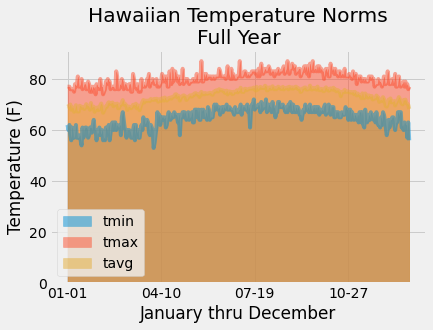

In [33]:
daily_normal_tobs_df = daily_normal_tobs_df.rename(columns={"MIN(m.tobs)": "tmin", "MAX(m.tobs)": "tmax", "AVG(m.tobs)": "tavg"})

ax = daily_normal_tobs_df.plot.area(stacked=False, title=f'Hawaiian Temperature Norms\nFull Year')

plt.xlabel('January thru December')
plt.ylabel('Temperature (F)')

### SQLalchemy - Daily Rainfall and Tempeature - 3. Function to extract Daily Temperature Normals for a specific day of the year

In [34]:
def daily_temp_norms(month_day_value):
    daily_temp_values = daily_normal_tobs_df.loc['04-04']
    return daily_temp_values

# function usage example
print(f"\nDaily normals: low, high, average in Fahrenheit for the day of year entered\n")
print(round(daily_temp_norms('04-04'),1))


Daily normals: low, high, average in Fahrenheit for the day of year entered

tmin    58.0
tmax    78.0
tavg    72.0
Name: 04-04, dtype: float64


### SQLalchemy - Daily Rainfall and Temperature - 4. Vacation Planner - function to provide Daily Normals Using Any Dates in the Future¶
### SQLalchemy - Daily Rainfall and Temperature - 5. Load the Daily Normals for Vacation Period into a dataframe

In [35]:
print(f"Hello!  Think of a 2 week vacation in beautiful Hawaii.\n")
vaca_start_date_str = input('Using the YYYY-MM-DD date format, enter your ideal vacation start date: ')

vaca_start_date = pd.to_datetime(vaca_start_date_str)
vaca_end_date = vaca_start_date + pd.offsets.DateOffset(weeks=2)
vaca_end_date_str = str(vaca_end_date).split(" ")[0]

weekday_vaca_start = calendar.day_name[vaca_start_date.weekday()]
weekday_vaca_end = calendar.day_name[vaca_end_date.weekday()]

month_vaca_start = vaca_start_date.strftime("%B")
year_vaca_start = vaca_start_date.strftime("%Y")

print(f"\nThank you!  You have chosen a 2 week fantasy vacation in Hawaii beginning in {month_vaca_start} {year_vaca_start}.")
print(f"We have scheduled you to arrive {weekday_vaca_start}, {vaca_start_date_str} and depart {weekday_vaca_end}, {vaca_end_date_str}.")

# Generate a list of dates of the upcoming scheduled vacation
vacation_dates_str = []

vacation_dates = pd.date_range(vaca_start_date,vaca_end_date-timedelta(days=1),freq='d')

for dates_y in vacation_dates:
    dates_y_str = dates_y.strftime("%Y-%m-%d")
    vacation_dates_str.append(dates_y_str)

vacation_dates_str_ser = pd.Series(vacation_dates_str)

# Strip out the years in the string dates to yield a list of month-days
vaca_md_list = []
vacation_dates_str_ser
for vaca_date in vacation_dates_str_ser:
    vals_x = str(vaca_date).split("-")
    vaca_month_day = vals_x[1] + "-" + vals_x[2]
    vaca_md_list.append(vaca_month_day)

vaca_month_day_df = pd.DataFrame(vaca_md_list)
vaca_month_day_df = vaca_month_day_df.sort_values(by=[0])
vaca_set = vaca_month_day_df[0]

# Query for specific month-dates corresponding to our travel dates against the full year dataframe
vaca_daily_normals = []
daily_normal_tobs_df2 = daily_normal_tobs_df.reset_index()
for vaca_md in vaca_set:
    u = daily_normal_tobs_df2.loc[daily_normal_tobs_df2['month-day'] == vaca_md]
    vaca_daily_normals.append(u)

# Reshape list of dataframes (366 of them, in fact) to single dataframe
vaca_daily_normals_df = pd.concat(vaca_daily_normals) # vaca_daily_normals is actually a list of dataframes
vaca_daily_normals_df.reset_index(drop=True,inplace=True)
vaca_daily_normals_df.set_index('month-day', inplace=True)
global vaca_daily_normals_df
vaca_daily_normals_df

Hello!  Think of a 2 week vacation in beautiful Hawaii.

Using the YYYY-MM-DD date format, enter your ideal vacation start date: 2021-04-04

Thank you!  You have chosen a 2 week fantasy vacation in Hawaii beginning in April 2021.
We have scheduled you to arrive Sunday, 2021-04-04 and depart Sunday, 2021-04-18.


,tmin,tmax,tavg
month-day,,,
04-04,58.0,78.0,72.016393
04-05,61.0,80.0,72.288136
04-06,67.0,77.0,71.571429
04-07,63.0,78.0,71.105263
04-08,66.0,77.0,72.105263
04-09,62.0,78.0,71.614035
04-10,64.0,79.0,71.403509
04-11,65.0,82.0,72.491803
04-12,65.0,80.0,72.224138


### SQLalchemy - Daily Rainfall and Temperature - 6b. Plot Daily Temperature Normals for Vacation Trip

Text(0, 0.5, 'Temperature (F)')

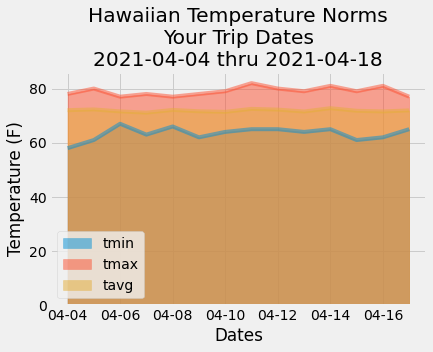

In [36]:
vaca_daily_normals_df = vaca_daily_normals_df.rename(columns={"MIN(m.tobs)": "tmin", "MAX(m.tobs)": "tmax", "AVG(m.tobs)": "tavg"})

ax = vaca_daily_normals_df.plot.area(stacked=False, title=f'Hawaiian Temperature Norms\nYour Trip Dates\n\
{vaca_start_date_str} thru {vaca_end_date_str}')

plt.xlabel('Dates')
plt.ylabel('Temperature (F)')

## SQLalchemy - Data Analyses - (2) Temperature Analysis I (part a)
* Monthly average temperature across all Hawaiian weather stations -- June vs. December
* Method ensures each date gets equal weight

In [37]:
month_tobs_avg_set = []

query_month_list = ('06','12')
for query_month in query_month_list:

    query = f'''
            SELECT
                AVG(mo_davg) as mavg
            FROM (
                SELECT
                    mo_date,
                    AVG(mo_tobs) AS mo_davg
                FROM
                    (SELECT m.date AS mo_date, m.tobs AS mo_tobs, strftime('%m',m.date) as month 
                    FROM measurement m WHERE month = '{query_month}')
                GROUP BY
                    mo_date
                ) as M
            '''
    month_tobs_avg = pd.read_sql(query, conn)
    month_tobs_avg_x = month_tobs_avg.values.flatten().tolist()
    month_tobs_avg_set.append(month_tobs_avg_x)
    month_tobs_avg_df = pd.DataFrame(month_tobs_avg_set)

month_tobs_avg_df['month'] = query_month_list
month_tobs_avg_df.columns = ['Mo Avg Tem', 'Month']
month_tobs_avg_df.reset_index(drop=True,inplace=True)
month_tobs_avg_df.set_index('Month',inplace=True)
month_tobs_avg_df

,Mo Avg Tem
Month,
06,75.010911
12,71.105334


## SQLalchemy - Data Analyses - (2) Temperature Analysis I (part b)
* Use the t-test to determine whether the difference in means if statistically significant

In [38]:
# I had a really hard time figuring out how to pull the first two values for each cell of the index
# I used these values (the month value in the month-day composite value) to match against the months of June and December
daily_normal_tobs_df.head()
df_a = daily_normal_tobs_df
daily_normals_tobs_june = df_a.loc[df_a.index.str[0:2] == '06']
daily_normals_tobs_june.columns = ['june tdmin', 'june tdmax', 'june tdavg']
print(f"\nDaily Normals for the Month of June -- {len(daily_normals_tobs_june)} rows")
daily_normals_tobs_june.head()


Daily Normals for the Month of June -- 30 rows


,june tdmin,june tdmax,june tdavg
month-day,,,
06-01,64.0,81.0,74.614035
06-02,65.0,81.0,74.400000
06-03,65.0,80.0,74.034483
06-04,65.0,81.0,73.818182
06-05,68.0,81.0,74.854545


In [39]:
daily_normal_tobs_df.head()
df_a = daily_normal_tobs_df
daily_normals_tobs_decem = df_a.loc[df_a.index.str[0:2] == '12']
daily_normals_tobs_decem.columns = ['decem tdmin', 'decem tdmax', 'decem tdavg']
print(f"\nDaily Normals for the Month of December -- {len(daily_normals_tobs_decem)} rows")
daily_normals_tobs_decem.head()


Daily Normals for the Month of December -- 31 rows


,decem tdmin,decem tdmax,decem tdavg
month-day,,,
12-01,65.0,78.0,71.916667
12-02,62.0,77.0,71.326923
12-03,67.0,79.0,72.886792
12-04,66.0,81.0,72.176471
12-05,64.0,78.0,70.921569


In [40]:
df_b1 = daily_normals_tobs_june.reset_index()
df_b2 = daily_normals_tobs_decem.reset_index()
df_c = df_b1.merge(df_b2, left_index=True, right_index=True, how='inner')
df_c.head()

,month-day_x,june tdmin,june tdmax,june tdavg,month-day_y,decem tdmin,decem tdmax,decem tdavg
0,06-01,64.0,81.0,74.614035,12-01,65.0,78.0,71.916667
1,06-02,65.0,81.0,74.400000,12-02,62.0,77.0,71.326923
2,06-03,65.0,80.0,74.034483,12-03,67.0,79.0,72.886792
3,06-04,65.0,81.0,73.818182,12-04,66.0,81.0,72.176471
4,06-05,68.0,81.0,74.854545,12-05,64.0,78.0,70.921569


In [41]:
df_c = df_c[['june tdavg', 'decem tdavg']]
print(f'Hawaii Mean Temp June and December \n{df_c.mean()}\n')
print(f'Hawaii STD Temp June and December \n{df_c.std()}')

june = df_c['june tdavg']
december = df_c['decem tdavg']

df_c.head()

Hawaii Mean Temp June and December 
june tdavg     74.946926
decem tdavg    71.129982
dtype: float64

Hawaii STD Temp June and December 
june tdavg     0.573293
decem tdavg    0.977640
dtype: float64


,june tdavg,decem tdavg
0,74.614035,71.916667
1,74.400000,71.326923
2,74.034483,72.886792
3,73.818182,72.176471
4,74.854545,70.921569


In [42]:
df_c['X-Y'] = df_c['june tdavg'] - df_c['decem tdavg'] 
df_c['(X-Y)^2'] = df_c['X-Y'] ** 2

df_c.head()

,june tdavg,decem tdavg,X-Y,(X-Y)^2
0,74.614035,71.916667,2.697368,7.275796
1,74.400000,71.326923,3.073077,9.443802
2,74.034483,72.886792,1.147690,1.317193
3,73.818182,72.176471,1.641711,2.695216
4,74.854545,70.921569,3.932977,15.468307


In [43]:
# T-test with SciPy 
res = stats.ttest_ind(june, december, equal_var=True)
display(res)

Ttest_indResult(statistic=18.446704310127817, pvalue=6.098480343543974e-26)

In [44]:
# Two-Sample T-test with Pingouin
res = pg.ttest(june, december, correction=False)
display(res)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,18.446704,58,two-sided,6.098480e-26,"[3.4, 4.23]",4.762919,3.115e+22,1.0


In [45]:
# T-test with Statsmodels
ttest_ind(june, december)

(18.44670431012775, 6.098480343545103e-26, 58.0)

#### T-Score Analysis
The T-score is a ratio between the difference between two groups and the difference within the groups. The larger the T-score, the more difference there is between groups. The smaller the T-score, the more similarity there is between groups. A T-score of 3 means that the groups are 3x as different from each other as they are within each other. When you run a T-ttest, the bigger the T-value, the more likely it is that the results are repeatable.  So, the T-score of 18 in our analysis suggests that the temperature differences are 18x greater between the June and December groups are 18x greater than they are within their own groups.

#### P-Value Analysis
It is inappropriate to interpret the P-value of 6.1 as a trend towards a difference. The P-value means that there is a probability of 6.1% of obtaining that result by chance rather than there being a real difference between between June and December temperatures. Because we set the significance level at 5%, the null hypothesis should not be rejected. So, what we have in this case is a small but still statistically significant chance that the differences could be the result of chance.

#### Effect Size (Cohen’s D)
One common way to interpret Cohen’s D that is obtained in a T-test is in terms of the relative strength of e.g. the condition. Cohen (1988) suggested that d=0.2 should be considered a ‘small’ effect size, 0.5 is a ‘medium’ effect size, and that 0.8 is a ‘large’ effect size. This means that if two groups’ means don’t differ by 0.2 standard deviations or more, the difference is trivial, even if it is statistically significant.  In the case of this analysis, the value of 4.8 is well north of these thresholds and points to strong significance.

#### Bayes Factors (BF10)
A Bayes factor is the ratio of the likelihood of one particular hypothesis to the likelihood of another. It can be interpreted as a measure of the strength of evidence in favor of one theory among two competing theories, H1 and H2.  According to one of the most common interpretations of BF, first proposed by Harold Jeffereys (1961) and slightly modified by Lee and Wagenmakers in 2013, any factor above 100 is "Extreme evidence for H1".  Given the BF10 value we calculated, we surmise extreme evidence that the mean temperature differences we calculated are related to seasonality.

#### Degrees of Freedom (DOF)

Typically, DOF equals your sample size minus the number of parameters you need to calculate during an analysis.  DOF is a combination of how much data you have and how many parameters you need to estimate. It indicates how much independent information goes into a parameter estimate. Our DOF calculation of 58 suggests that our data set easily covers our ability to test the parameters we are testing.

#### Two-Tailed T-Test
The two-tailed T-Test tests for whether the mean of a sample is significantly greater than or significantly less than the mean of a population is referred to as a two-tailed test.  A two-tailed test is designed to examine both sides of a specified data range as designated by the probability distribution involved. 

#### Conclusion
The first part of our analysis supports the idea that Hawaii enjoys relatively mild weather year-round, at least based on our sample of temperature measurements for June and December.  There is a mere 3-4 degrees F difference between the periods.  The June STD was nearly 0.6 degrees F, and the December STD was just shy of 1.0 degree F.

The second part of our analysis, the T-test, indicates that our testing method for assessing whether the variations between the June and December temperature observation sets was adequate, with 58 DOF.  The T-score (18), Effect Size (4.8), and BF10 score (off the scale) supported the idea that the temperature variations apparently due to seasonality are significant.  Nonetheless, there is a small but sigificant probability (6%) that the differences we observe in our multiyear sample are explainable as random chance.

## SQLalchemy - Data Analyses - (3) Temperature Analysis II

We developed the vacation planner solution earlier in this Jupyter Notebook in the Step 1. section, under the title "SQLalchemy - Station Data - Vacation Planner Using Any Dates in the Future".  It calculated TMIN, TMAX, and TAVG "normals" for the vacation period in question (based on month-day grouping).

Text(0, 0.5, 'Temperature (F)')

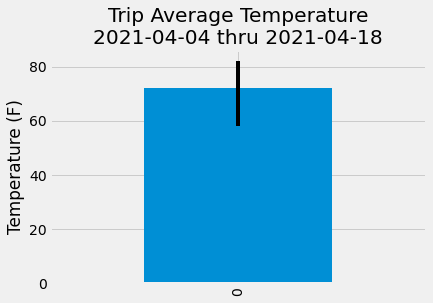

In [46]:
vaca_temp_df["wavg_t"].plot(kind='bar',
                            yerr=[[vaca_temp_df['wavg_t']-vaca_temp_df['min_t'], vaca_temp_df['max_t']-vaca_temp_df['wavg_t']]],
                            title=f'Trip Average Temperature\n{vaca_start_date_str} thru {vaca_end_date_str}')

plt.ylabel('Temperature (F)')